In [1]:
%run ~/Documents/Projects/scripts/init.ipy
os.chdir(os.getcwd().replace('pipeline/notebooks', ''))

In [2]:
results = []
for infile in glob.glob('./s3-differential_expression.dir/*-control_vs_RL-limma.txt'):
    data = pd.read_table(infile)
    comparison = os.path.basename(infile).split('-')[0]#.replace('kallisto', 'all')
    if comparison != 'kallisto':
        data['comparison'] = comparison
        results.append(data)
result_dataframe = pd.concat(results)
result_dataframe['logp'] = -np.log10(result_dataframe['P.Value'])

In [3]:
result_dataframe.head()

gene_symbol     logFC   AveExpr         t   P.Value  adj.P.Val  \
KLF6         KLF6  0.347966  8.658312  6.302804  0.000010   0.121707   
MGLL         MGLL  0.228428  8.451446  5.763352  0.000028   0.121707   
PKDCC       PKDCC -0.451379  3.061949 -5.811863  0.000025   0.121707   
RORA         RORA  0.283181  4.727606  5.438600  0.000052   0.121707   
BCAR3       BCAR3  0.560363  6.793813  5.236339  0.000078   0.121707   

              B comparison      logp  
KLF6   3.689242    AHF2617  5.003928  
MGLL   2.690525    AHF2617  4.558250  
PKDCC  2.537035    AHF2617  4.599021  
RORA   2.127003    AHF2617  4.281873  
BCAR3  1.711091    AHF2617  4.106811

/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'




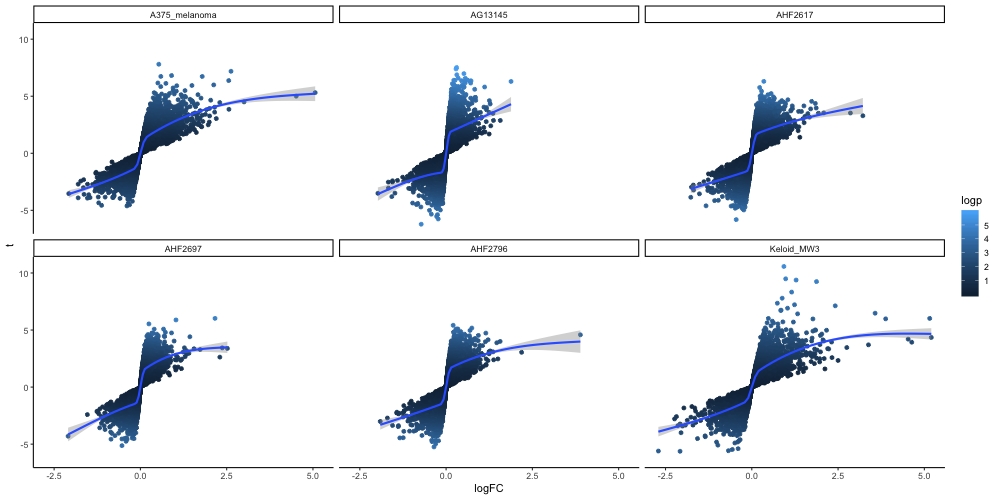

In [30]:
%%R -i result_dataframe -h 500 -w 1000
ggplot(result_dataframe, aes(x=logFC, y=t, color=logp)) + geom_point() + theme_classic() + facet_wrap(~comparison) + geom_smooth()

In [4]:
up = result_dataframe[(result_dataframe['P.Value'] < 0.05) & (result_dataframe['logFC'] > 0)].groupby('comparison').size().rename('up').to_frame()
down = result_dataframe[(result_dataframe['P.Value'] < 0.05) & (result_dataframe['logFC'] < 0)].groupby('comparison').size().rename('down').to_frame()
merged = up.merge(down, left_index=True, right_index=True).sort_values('up', ascending=False)
# merged = pd.melt(up.merge(down, left_index=True, right_index=True).reset_index(), id_vars='comparison')
merged.head()

up  down
comparison               
AG13145        1314  1204
AHF2617        1132   867
AHF2796        1022   732
AHF2697         910   625
A375_melanoma   756   420

In [5]:
%%R -i merged
merged

/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



                up down
AG13145       1314 1204
AHF2617       1132  867
AHF2796       1022  732
AHF2697        910  625
A375_melanoma  756  420
Keloid_MW3     658  391


[1] "AG13145"       "AHF2617"       "AHF2796"       "AHF2697"      
[5] "A375_melanoma" "Keloid_MW3"   


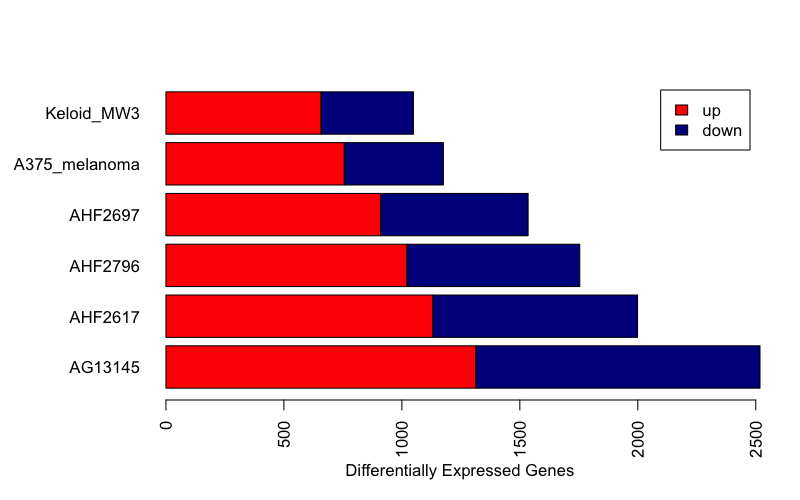

In [10]:
%%R -h 500 -w 800 -r 100
par(las=2)
par(mar=c(5,8,4,2))
print(rownames(merged))
barplot(as.matrix(t(merged)), names.arg=rownames(merged),horiz=TRUE,
  xlab="Differentially Expressed Genes", col=c("red","darkblue"),
  legend = colnames(merged))

In [11]:
%%R -i merged -h 750 -w 1000 -r 200
ggplot(merged, aes(x=t, color=comparison)) + 
    geom_density() +
#     scale_fill_gradient2() + 
#     geom_text(aes(label=value_format), color='white', size=3) +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), axis.title.x = element_text(vjust=-1), axis.title.y = element_text(vjust=2.5), axis.line = element_line(colour = 'black', size=0.2), strip.background = element_rect(color='black', fill='white', size=0), plot.title = element_text(hjust = 0.5))

RRuntimeError: Error in FUN(X[[i]], ...) : object 'comparison' not found


In [59]:
result_dataframe[result_dataframe['P.Value'] < 0.05].groupby('comparison').size()

comparison
A375_melanoma    1176
AG13145          2518
AHF2617          1999
AHF2697          1535
AHF2796          1754
Keloid_MW3       1049
dtype: int64

In [121]:
ss.spearmanr(t_dataframe.AHF2617, t_dataframe.AHF2697)

SpearmanrResult(correlation=0.5472585708298153, pvalue=0.0)

In [13]:
t_dataframe = result_dataframe.pivot(index='gene_symbol', columns='comparison', values='t').dropna()#fillna(0)
print(len(t_dataframe.index))
t_dataframe.head()


13567


comparison   A375_melanoma   AG13145   AHF2617   AHF2697   AHF2796  Keloid_MW3
gene_symbol                                                                   
A1BG             -0.467009 -1.167111 -0.950476 -0.808430 -0.451763   -1.355494
A1BG-AS1          0.222828  0.711804  0.544289  0.595326 -0.944306    1.768886
A4GALT           -1.205374  0.593860 -0.360402 -0.436127 -0.206718   -1.674225
AAAS             -0.748407 -1.645049 -1.765270 -0.816692 -1.894539   -0.183156
AACS              0.559264  0.371722  1.417195 -1.315344  2.596137    0.020944

In [14]:
description = t_dataframe.drop('A375_melanoma', axis=1).T.describe().T
description.head()

count      mean       std       min       25%       50%  \
gene_symbol                                                            
A1BG           5.0 -0.946655  0.346334 -1.355494 -1.167111 -0.950476   
A1BG-AS1       5.0  0.535200  0.967704 -0.944306  0.544289  0.595326   
A4GALT         5.0 -0.416722  0.813978 -1.674225 -0.436127 -0.360402   
AAAS           5.0 -1.260941  0.735240 -1.894539 -1.765270 -1.645049   
AACS           5.0  0.618131  1.475355 -1.315344  0.020944  0.371722   

                  75%       max  
gene_symbol                      
A1BG        -0.808430 -0.451763  
A1BG-AS1     0.711804  1.768886  
A4GALT      -0.206718  0.593860  
AAAS        -0.816692 -0.183156  
AACS         1.417195  2.596137

/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



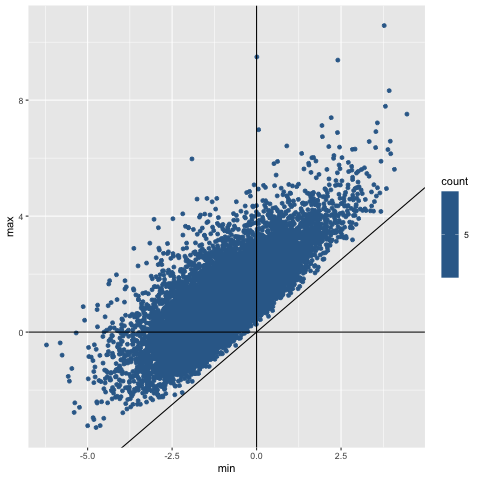

In [15]:
%%R -i description
ggplot(description, aes(x=min, y=max, color=count)) + geom_point() + geom_abline(intercept=0, slope=1)+
    geom_density2d() +
    geom_hline(yintercept=0) + 
    geom_vline(xintercept=0)

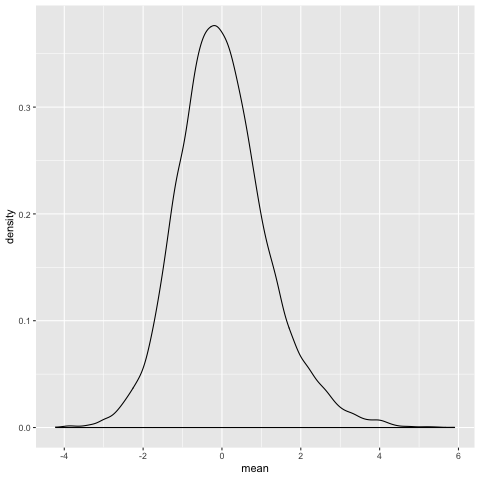

In [16]:
%%R -i description
ggplot(description, aes(x=mean)) + geom_density()

/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.




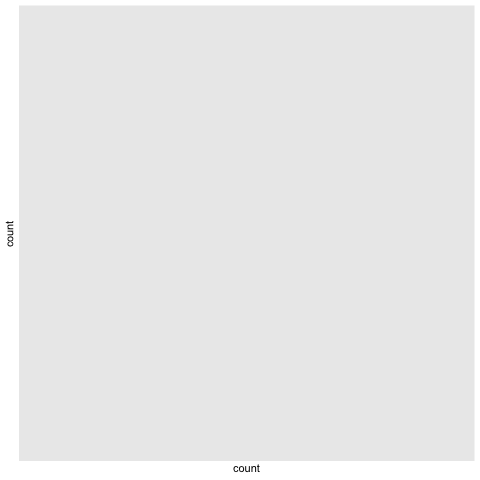

In [17]:
%%R -i description
ggplot(description, aes(x=count)) + geom_histogram()

In [18]:
def plot_unity(xdata, ydata, **kwargs):
    mn = -10
    mx = 10
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color='k', marker=None,
            linestyle='--', linewidth=1.0)

/Users/denis/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



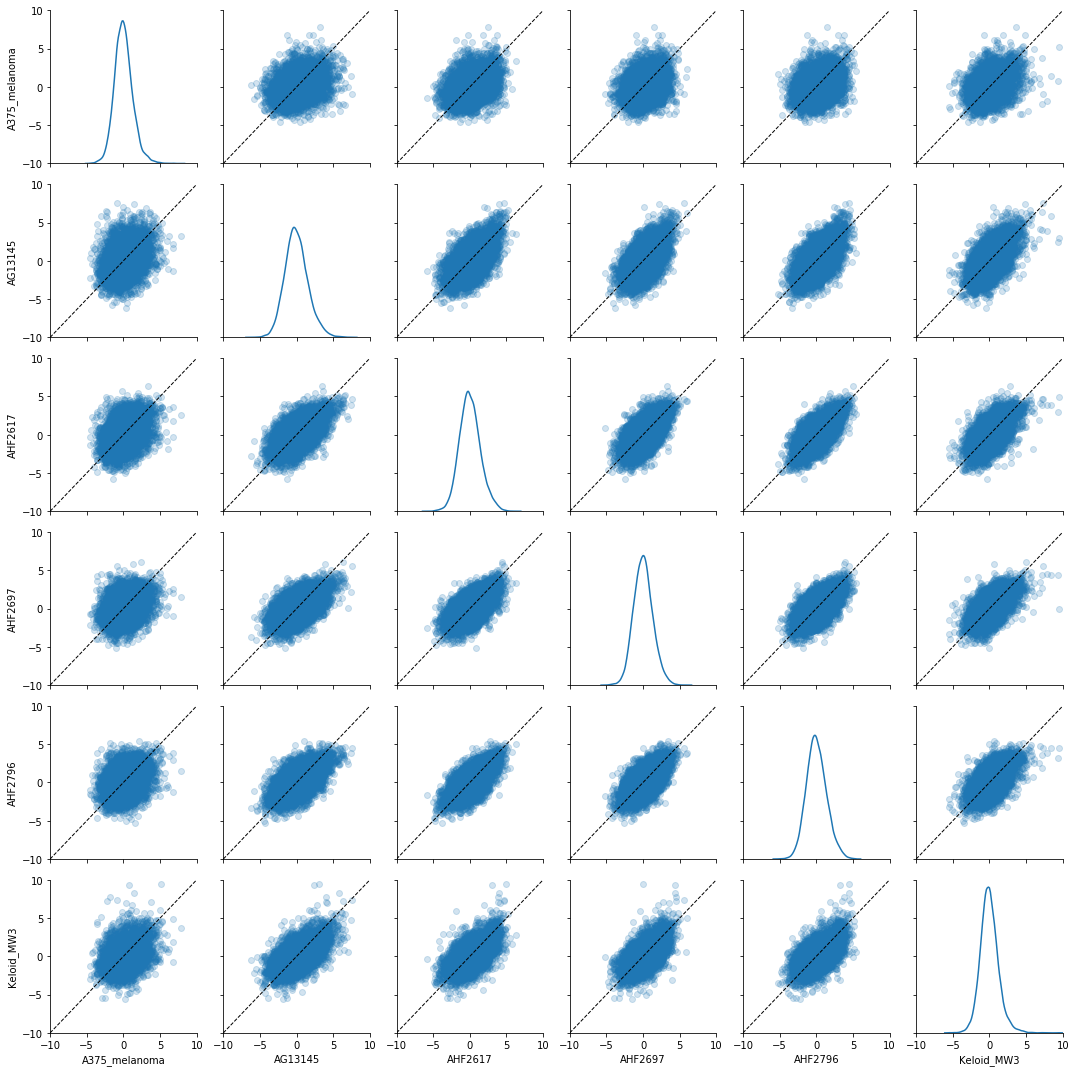

In [20]:
# sns.set_style("white");
lim = (-10, 10)
g = sns.PairGrid(t_dataframe)
g = g.map_offdiag(plt.scatter, alpha=0.2)
g = g.map_offdiag(plot_unity)
g = g.map_diag(sns.kdeplot)
g.set(ylim=lim, xlim=lim)

In [21]:
corr_dataframe = t_dataframe.corr(method='spearman').rename_axis('cell_line')

corr_dataframe.head()

comparison     A375_melanoma   AG13145   AHF2617   AHF2697   AHF2796  \
cell_line                                                              
A375_melanoma       1.000000  0.307777  0.344404  0.299681  0.284423   
AG13145             0.307777  1.000000  0.547433  0.532938  0.574837   
AHF2617             0.344404  0.547433  1.000000  0.547259  0.656855   
AHF2697             0.299681  0.532938  0.547259  1.000000  0.594889   
AHF2796             0.284423  0.574837  0.656855  0.594889  1.000000   

comparison     Keloid_MW3  
cell_line                  
A375_melanoma    0.369591  
AG13145          0.565051  
AHF2617          0.594182  
AHF2697          0.556020  
AHF2796          0.556362

In [22]:
metadata_dataframe = pd.read_table('./rawdata/metadata/sample_metadata_processed.txt')[['cell_line', 'cell_type']].drop_duplicates().set_index('cell_line')
metadata_dataframe

cell_type
cell_line                       
AG13145        normal_fibroblast
AHF2617        normal_fibroblast
AHF2796        normal_fibroblast
AHF2697        normal_fibroblast
Keloid_MW3     keloid_fibroblast
A375_melanoma           melanoma

/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



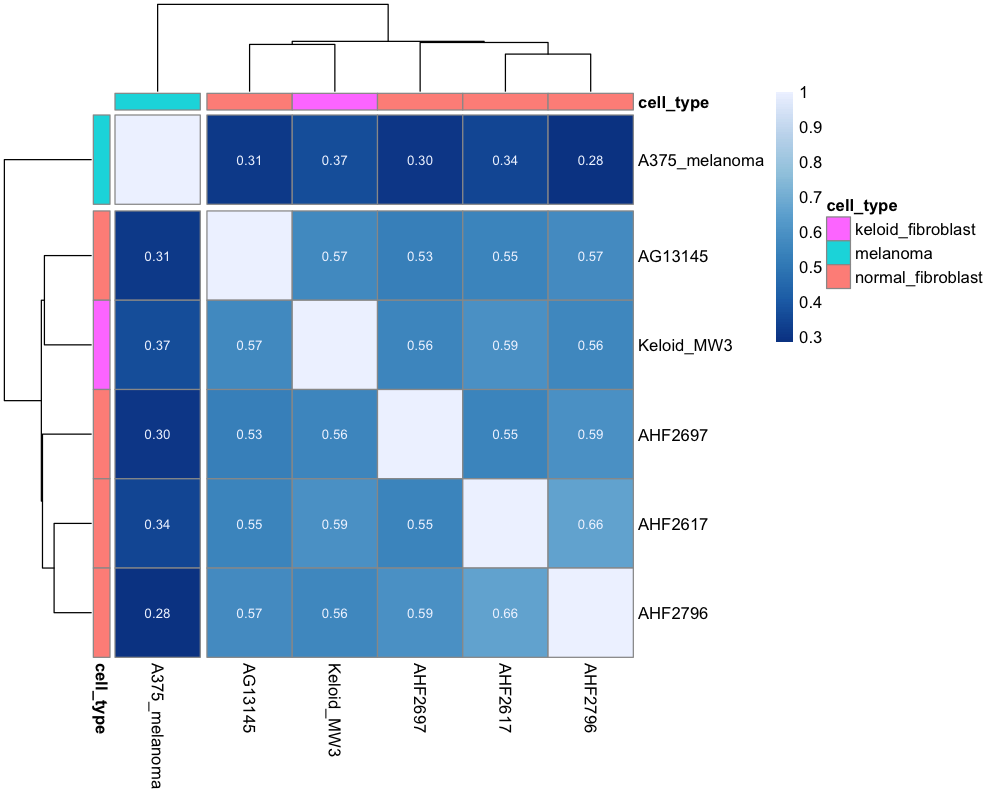

In [23]:
%%R -i corr_dataframe,metadata_dataframe -h 800 -w 1000 -r 120
pheatmap::pheatmap(corr_dataframe,
                   display_numbers=TRUE,
                   number_color='#eff4ff',
                   cutree_rows=2,
                   cutree_cols=2,
                   annotation_col=metadata_dataframe,
                   annotation_row=metadata_dataframe,
                   color = colorRampPalette(rev(brewer.pal(n = 7, name ="Blues")))(100))

In [9]:
corr_plot_dataframe = pd.melt(corr_dataframe.reset_index(), id_vars='cell_line')
corr_plot_dataframe['value_format'] = [str(round(x, ndigits=2)) if x != 1 else '' for x in corr_plot_dataframe['value']]
corr_plot_dataframe.head()

cell_line     comparison     value value_format
0  A375_melanoma  A375_melanoma  1.000000             
1        AG13145  A375_melanoma  0.307777         0.31
2        AHF2617  A375_melanoma  0.344404         0.34
3        AHF2697  A375_melanoma  0.299681          0.3
4        AHF2796  A375_melanoma  0.284423         0.28

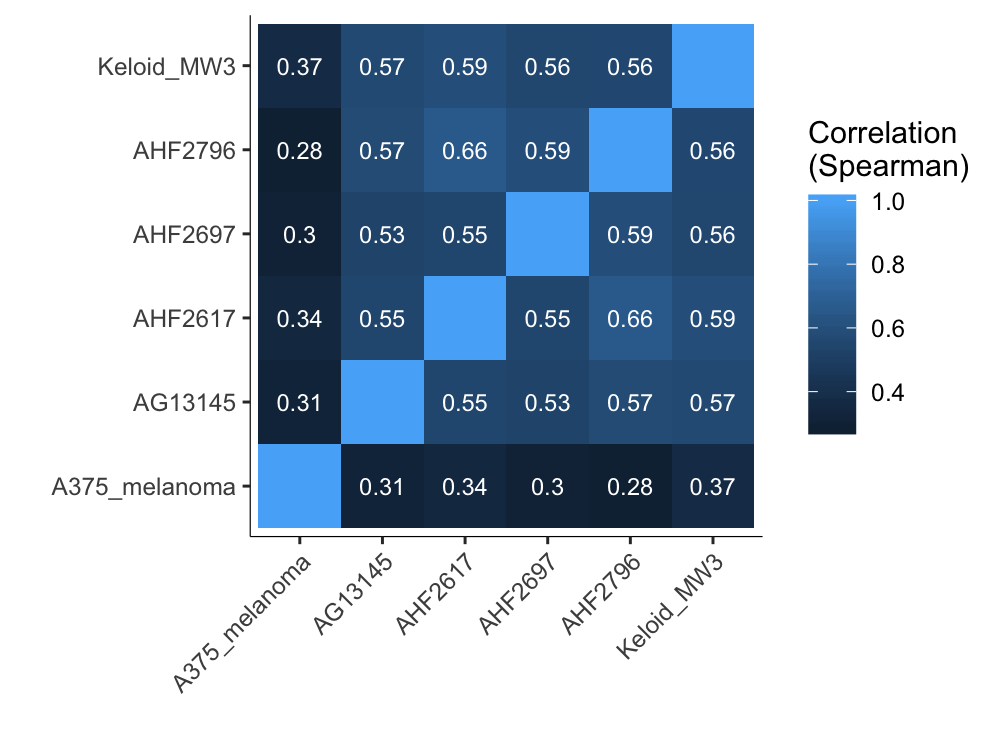

In [10]:
%%R -i corr_plot_dataframe -h 750 -w 1000 -r 200
ggplot(corr_plot_dataframe, aes(x=reorder(cell_line, cell_line), y=comparison, fill=value)) + 
    geom_tile() +
#     scale_fill_gradient2() + 
    geom_text(aes(label=value_format), color='white', size=3) +
    theme_classic() +
    labs(x='', y='', fill='Correlation\n(Spearman)') + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1), axis.title.x = element_text(vjust=-1), axis.title.y = element_text(vjust=2.5), axis.line = element_line(colour = 'black', size=0.2), strip.background = element_rect(color='black', fill='white', size=0), plot.title = element_text(hjust = 0.5))

In [15]:
%%R -i corr_dataframe
cluster <- hclust(dist(t(corr_dataframe)))
cluster


Call:
hclust(d = dist(t(corr_dataframe)))

Cluster method   : complete 
Distance         : euclidean 
Number of objects: 7 



In [17]:
%%R
cluster$order

[1] 1 2 6 4 5 3 7


In [ ]:
%%R -i result_dataframe
ggplot(result_dataframe)

In [41]:
def heatmaps(values='t'):

    print(len(result_dataframe.gene_symbol.unique()))
    t_dataframe = result_dataframe.pivot(index='gene_symbol', columns='comparison', values=values).dropna()#fillna(0)
    print(len(t_dataframe.index))
    t_dataframe.head()

    # Filter rows
    heatmap_dataframe = t_dataframe.loc[t_dataframe.var(axis=1).sort_values(ascending=False).index[:500]]

    sns.clustermap(heatmap_dataframe, cmap='RdBu_r');

    sns.clustermap(t_dataframe.corr())
    
    sns.pairplot(t_dataframe)

20041
12137


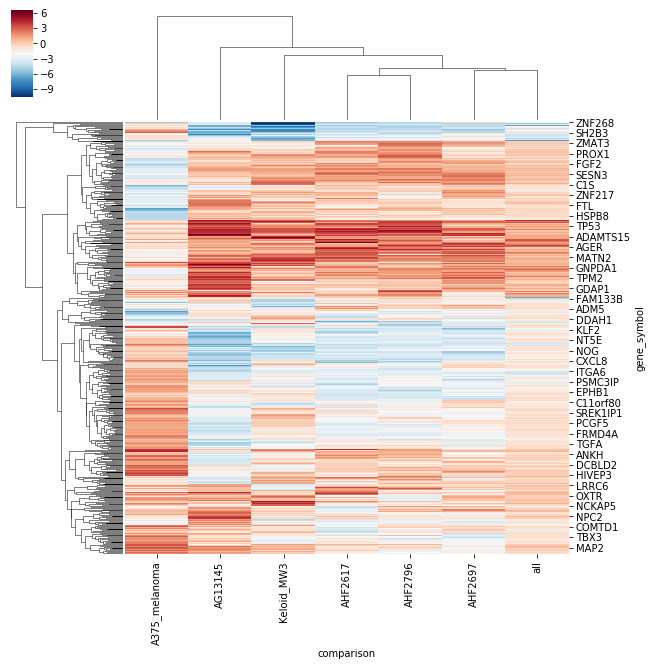

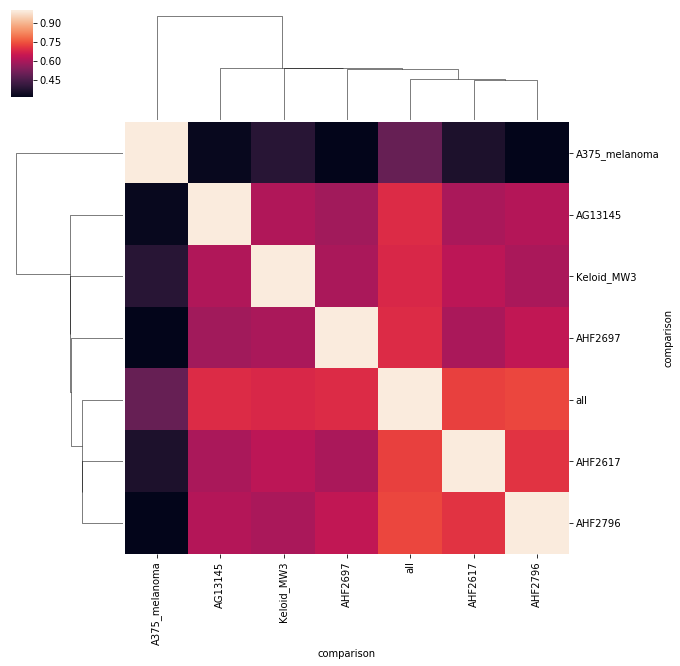

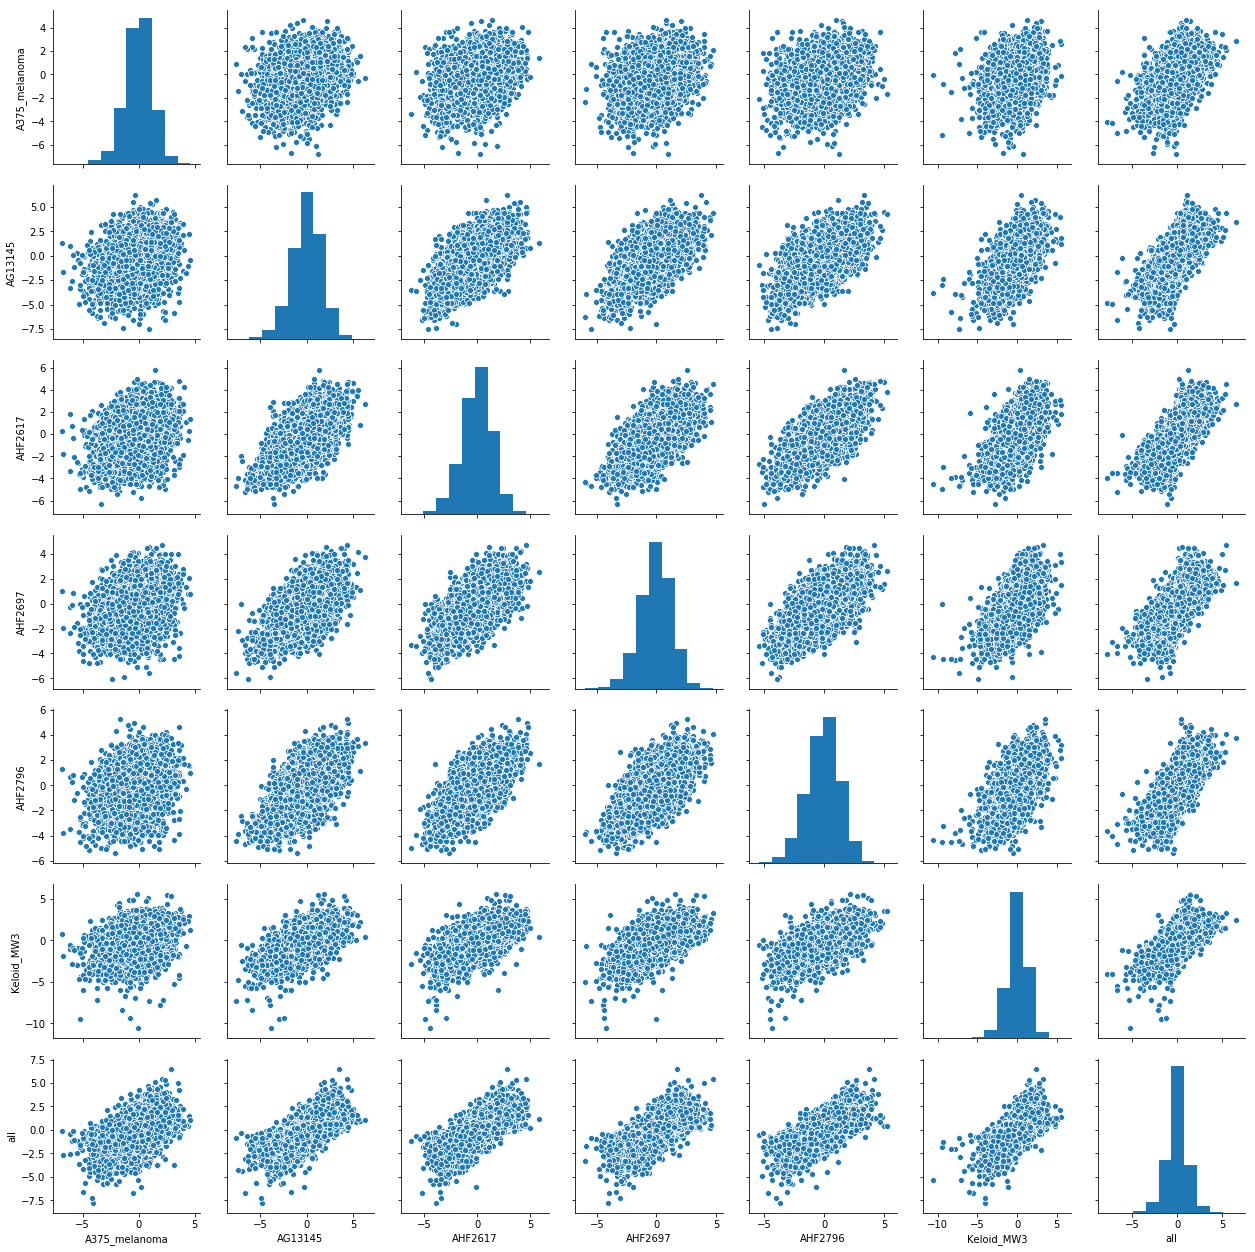

In [42]:
heatmaps('t')

20041
12137


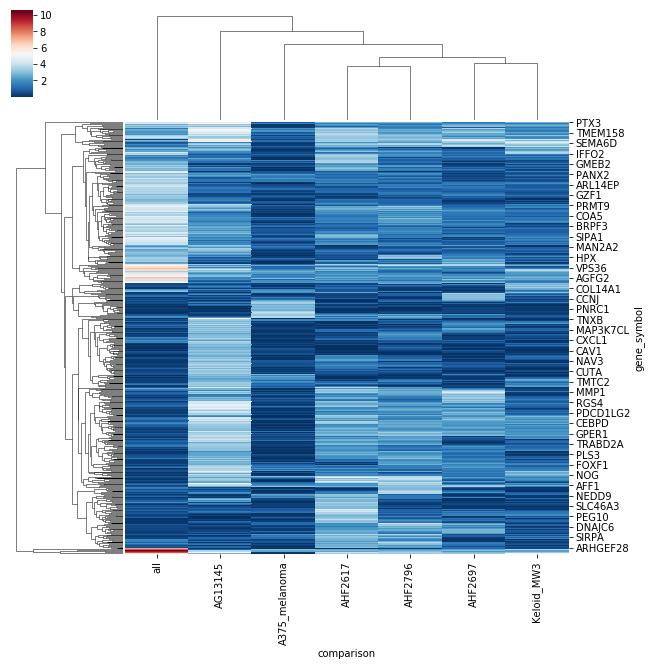

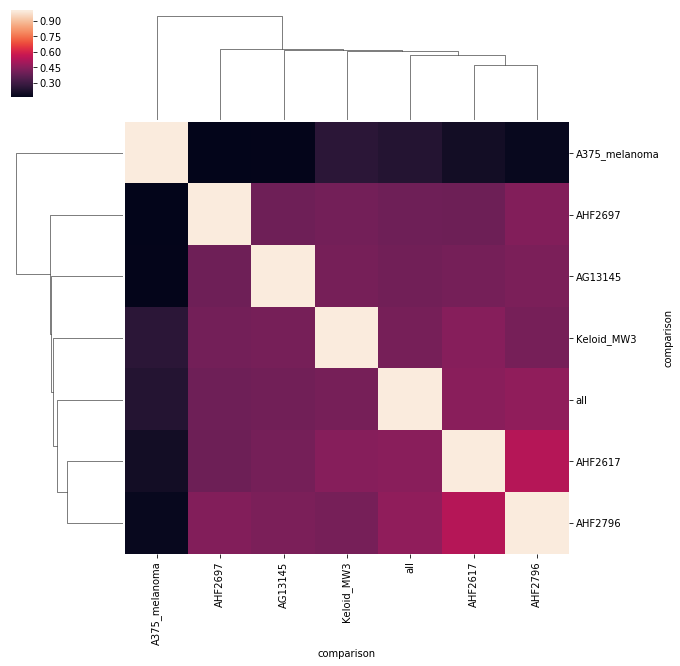

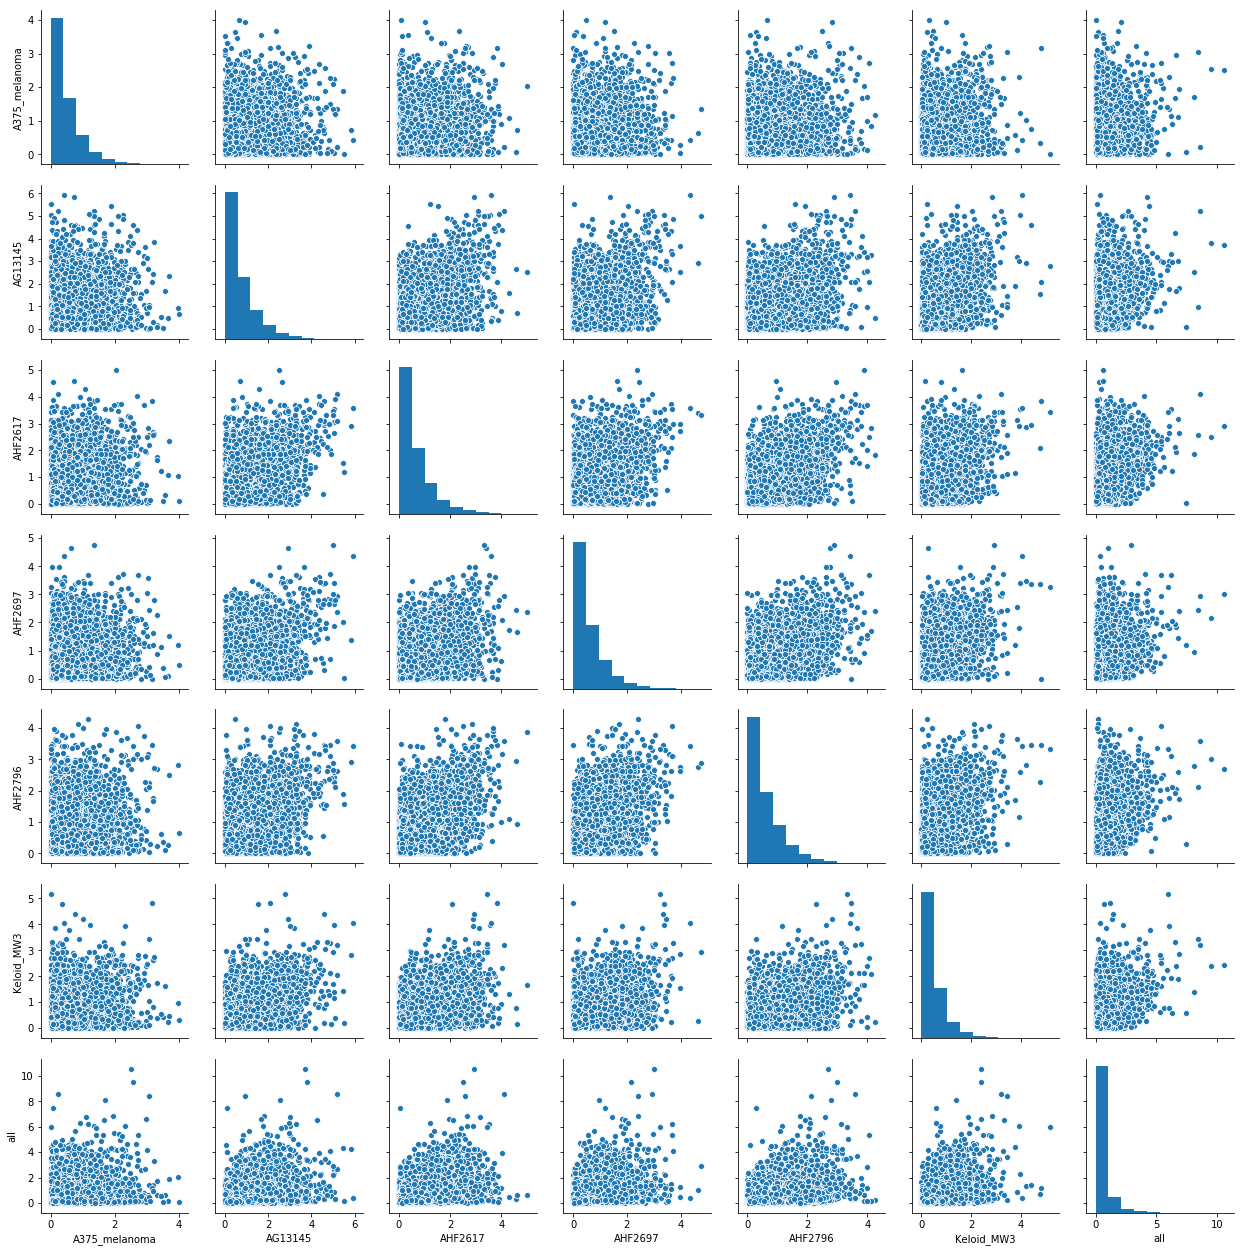

In [43]:
heatmaps('logp')

20041
12137


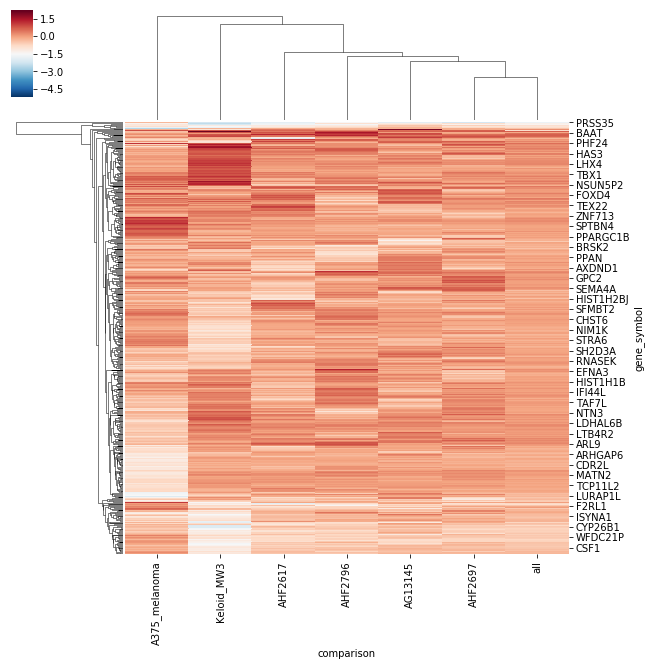

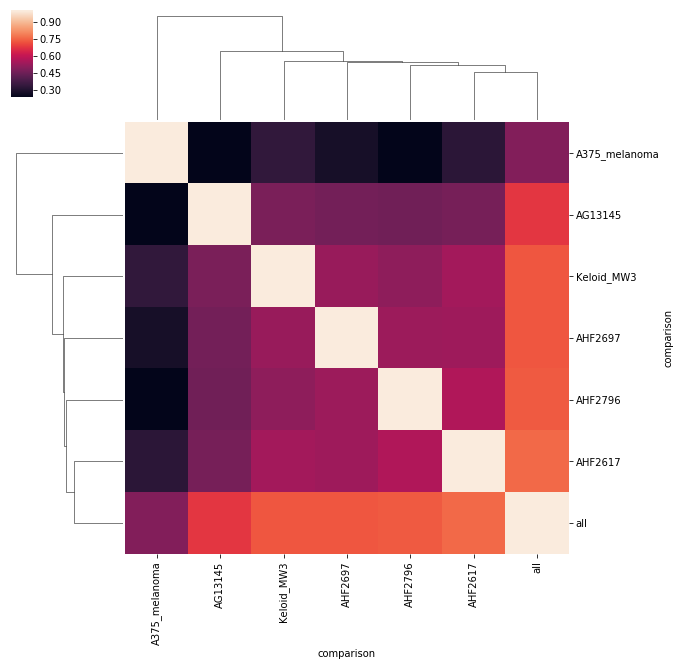

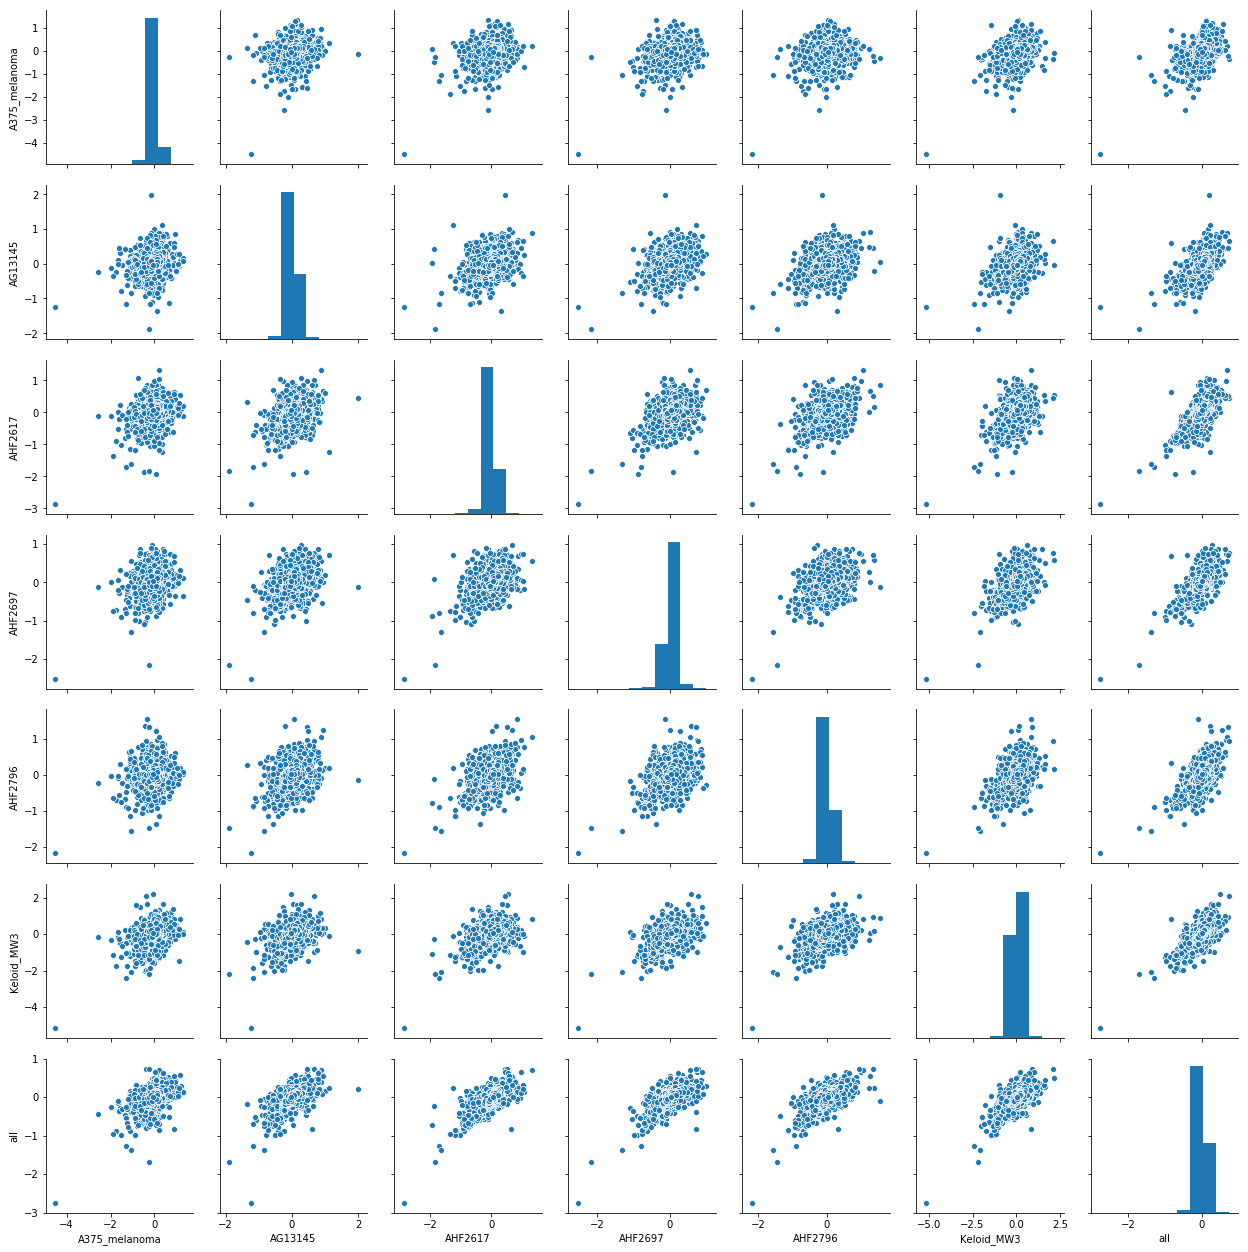

In [44]:
heatmaps('logFC')